In [1]:
import os
from copy import copy
import numpy as np
import pandas as pd

# 進度條
from tqdm import tqdm

# 分詞
from ckip_transformers import __version__
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from torch import cuda

# TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# LSI
from gensim import corpora, models

# Model
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings # BalancedRandomForestClassifier因版本問題，在訓練時會有大量future warning。引入warning將之關掉

# from sklearn 訓練用
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline

# 評估指標
from sklearn.metrics import precision_score, f1_score, confusion_matrix, classification_report

# 分類報告作圖
import matplotlib.pyplot as plt 
from yellowbrick.classifier import ClassificationReport

# 儲存模型用
import pickle

# **分詞**

In [4]:
# ckip分詞模型父資料夾
ckip_path = r"./ckiplab/"

# 新聞標題及label的表格路徑
folder_path = r"./history_tag"
# 用串列抓出所有路徑內的資料夾
folders = os.listdir(folder_path)

### 讀data檔

In [5]:
#讀檔時，會一直有future warning，告知未來datetime型式的欄位不會自動轉換。暫時關閉future warning
warnings.filterwarnings("ignore")

df_list = []
for folder in tqdm(folders, desc='讀取路徑內全部xslx檔案'):
    files = os.listdir(folder_path + "/" + folder)
    for file in files:
        tmp = pd.read_excel(folder_path + "/" + folder + "/" + file)
        tmp["Click"]=tmp["Click"].astype(str)
        tmp["DailyNews"]=tmp["DailyNews"].astype(str)
        try:
            df_list.append(tmp[["title","datetime","short_url","site","Click", "DailyNews"]])
        except:
            print(file)
content_df = pd.concat(df_list)
#啟動future warning
warnings.filterwarnings("default") 

讀取路徑內全部xslx檔案: 100%|████████████████████████████████████████████████████████████| 6/6 [00:18<00:00,  3.05s/it]


In [7]:
content_df = content_df.dropna(subset=['title'])
content_df.isnull().sum()

title        0
datetime     4
short_url    6
site         4
Click        0
DailyNews    0
dtype: int64

In [11]:
content_df.head(5)

,title,datetime,short_url,site,Click,DailyNews
0,集邦曝：面板需求不振、庫存嚴峻 各大廠稼動率被迫降載！,2022-07-19 09:31:00,https://tinyurl.com/2autglh3,ettoday財經雲,1,1
1,不是友達、群創！數位化車牌掀浪潮這公司才是面板產業的浮木,2022-07-19 13:54:23,https://tinyurl.com/2925b4m9,財訊,1,0
2,iPhone 14記憶體面板有雜音 郭明錤：蘋果硬體開發不受衰退影響,2022-07-20 07:52:00,https://tinyurl.com/2xlc2rt3,ettoday新聞雲,1,0
3,陳炫彬現身！滿頭白髮做AI 不做面板走新路,2022-07-19 14:14:30,https://tinyurl.com/2y22q29k,財訊,0,0
4,TCL 75吋 4K QLED電視6萬元有找 高CP值成年輕人最愛,2022-07-19 17:11:00,https://tinyurl.com/27gnnyl3,ettoday新聞雲,1,0


### 字元處理

In [8]:
content_df.DailyNews.value_counts()

nan     9056
0       7318
0.0     2031
1       1118
1.0     1113
V         78
股市        26
股票         2
股市期貨       1
\          1
Name: DailyNews, dtype: int64

In [9]:
content_df.Click.value_counts()

0        11601
nan       3405
1         3396
0.0       1302
1.0        817
V          108
股票          76
股市          26
股價相關         3
運動新聞         3
股價           3
股票..吧        2
股市期貨         1
基金           1
Name: Click, dtype: int64

In [10]:
uni_dict = {"0":0,"1":1,"0.0":0,"1.0":1,"V":1,0:0,1:1}
content_df.DailyNews = content_df.DailyNews.apply(lambda x : uni_dict[x] if x in uni_dict else np.nan)
content_df.DailyNews.value_counts()

C:\Users\BenBLLee\AppData\Local\Temp\ipykernel_5688\3693335006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.DailyNews = content_df.DailyNews.apply(lambda x : uni_dict[x] if x in uni_dict else np.nan)


0.0    9349
1.0    2309
Name: DailyNews, dtype: int64

In [11]:
uni_dict = {"0":0,"1":1,"0.0":0,"1.0":1,"V":1,0:0,1:1}
content_df.Click = content_df.Click.apply(lambda x : uni_dict[x] if x in uni_dict else np.nan)
content_df.Click.value_counts()

C:\Users\BenBLLee\AppData\Local\Temp\ipykernel_5688\3349800474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.Click = content_df.Click.apply(lambda x : uni_dict[x] if x in uni_dict else np.nan)


0.0    12903
1.0     4321
Name: Click, dtype: int64

In [15]:
content_df = content_df.dropna(subset=['Click', 'DailyNews'])

In [17]:
#暫時關閉future warning
warnings.filterwarnings("ignore")

# 去除非字元的字符
content_df.title = content_df.title.str.replace(r'\W', r'')
# 英文大寫
content_df.title = content_df.title.str.upper()
# 去除數字
content_df.title = content_df.title.str.replace(r'\d', r'')

#啟動future warning
warnings.filterwarnings("default") 

### CKIP Transformer分詞、詞性標註

In [19]:
# 裝置
device = 0 if cuda.is_available() else -1

# 建立分詞、詞性標記、命名實體物件
ws_driver = CkipWordSegmenter(model_name=ckip_path + 'albert-base-chinese-ws',device=device) # 分詞
pos_driver = CkipPosTagger(model_name=ckip_path + 'albert-base-chinese-pos',device=device)    # 詞性標記(POS)

In [20]:
ws = ws_driver(content_df.title)
pos = pos_driver(ws)

Inference: 100%|███████████████████████████████████████████████████████████████████████| 46/46 [13:52<00:00, 18.10s/it]


In [21]:
print(ws[1])

['不', '是', '友達', '群', '創', '數位化', '車牌', '掀', '浪潮', '這', '公司', '才', '是', '面板', '產業', '的', '浮木']


In [22]:
print(list(zip(ws[4], pos[4])))

[('TCL', 'FW'), ('吋', 'Nf'), ('KQLED', 'FW'), ('電視', 'Na'), ('萬', 'Neu'), ('元', 'Nf'), ('有', 'V_2'), ('找', 'VC'), ('高', 'VH'), ('CP', 'FW'), ('值', 'Na'), ('成', 'VG'), ('年輕人', 'Na'), ('最', 'Dfa'), ('愛', 'VL')]


### 移除部分詞性
把CKIP中的部分詞性的詞、以及前面設定的停用詞移除

In [25]:
# 用來保留主要詞彙的函式
def clean(sentence_ws, sentence_pos):
    short_with_pos = []
    short_sentence = []
    stop_pos = set(['Nep', 'Nh']) # 這 2種詞性不保留(指代定詞、代名詞)
    
    for word_ws, word_pos in zip(sentence_ws, sentence_pos):
        
        # 部分的分詞內有包含空白字元，會導致停用詞不會被辨識到，所以在這邊用replace處理掉空白字元
        word_ws = word_ws.replace(' ','')
        
        # 只留名詞和動詞
        is_N_or_V = word_pos.startswith("V") or word_pos.startswith("N") or word_pos.startswith("FW")
        # 去掉名詞裡的某些詞性(指代定詞、代名詞、專有名詞)
        is_not_stop_pos = word_pos not in stop_pos
        # 只剩一個字的詞也不留
        is_not_one_charactor = not (len(word_ws) == 1)
        
        # 組成串列
        if is_N_or_V and is_not_stop_pos and is_not_one_charactor:
            short_sentence.append(f"{word_ws}")
            
    return " ".join(short_sentence)

# 把前面的ws分詞、pos詞性標駐合併為同一個表格，並用apply套用上段函式
df = pd.DataFrame({'ws':pd.Series(ws), 'pos':pd.Series(pos)})
texts = df.apply(lambda row: clean(row.ws, row.pos),axis=1)
texts.head()

0            集邦 面板 需求 不振 庫存 嚴峻 稼動率 被迫 降載
1               友達 數位化 車牌 浪潮 公司 面板 產業 浮木
2    IPHONE 記憶體 面板 雜音 郭明錤 蘋果 硬體 開發 衰退 影響
3                        陳炫彬 現身 白髮 AI 面板
4                    TCL KQLED 電視 CP 年輕人
dtype: object

# **數據預處理**

### 讓後續模型在訓練時，用變數texts_df當作資料表

把分詞和斷詞後的texts，和原本content_df的click、dailynews欄位合併

In [26]:
texts.name = 'texts' # 先給texts一個欄位名稱
texts_df = pd.concat([texts, content_df.reset_index(drop=True)[['Click', 'DailyNews']]], axis=1) #合併表格
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584 entries, 0 to 11583
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   texts      11584 non-null  object 
 1   Click      11584 non-null  float64
 2   DailyNews  11584 non-null  float64
dtypes: float64(2), object(1)
memory usage: 271.6+ KB


把Click、dailynews轉型成float，以確認空值，並用0去補空值

In [98]:
content_df

,title,datetime,short_url,site,Click,DailyNews
0,集邦曝面板需求不振庫存嚴峻各大廠稼動率被迫降載,2022-07-19 09:31:00,https://tinyurl.com/2autglh3,ettoday財經雲,1.0,1.0
1,不是友達群創數位化車牌掀浪潮這公司才是面板產業的浮木,2022-07-19 13:54:23,https://tinyurl.com/2925b4m9,財訊,1.0,0.0
2,IPHONE記憶體面板有雜音郭明錤蘋果硬體開發不受衰退影響,2022-07-20 07:52:00,https://tinyurl.com/2xlc2rt3,ettoday新聞雲,1.0,0.0
3,陳炫彬現身滿頭白髮做AI不做面板走新路,2022-07-19 14:14:30,https://tinyurl.com/2y22q29k,財訊,0.0,0.0
4,TCL吋KQLED電視萬元有找高CP值成年輕人最愛,2022-07-19 17:11:00,https://tinyurl.com/27gnnyl3,ettoday新聞雲,1.0,0.0
...,...,...,...,...,...,...
182,資安需求高漲人才嚴重不足,2022-12-22 03:06:23,https://tinyurl.com/2pxr5hgs,工商時報,1.0,1.0
190,台科大首場外籍生徵才說明會華碩鈊象搶先攬才,2022-12-21 11:27:37,https://tinyurl.com/2pnn8mpo,聯合新聞網,1.0,1.0
214,傳特斯拉將於下季裁員並凍結招聘,2022-12-21 19:57:03,https://tinyurl.com/2fde2tgt,鉅亨網,1.0,1.0
218,美光將裁員大砍支出上季轉虧本季會更糟,2022-12-22 07:23:08,https://tinyurl.com/2otqhqza,聯合新聞網,0.0,1.0


In [29]:
texts_df

,texts,Click,DailyNews
0,集邦 面板 需求 不振 庫存 嚴峻 稼動率 被迫 降載,1.0,1.0
1,友達 數位化 車牌 浪潮 公司 面板 產業 浮木,1.0,0.0
2,IPHONE 記憶體 面板 雜音 郭明錤 蘋果 硬體 開發 衰退 影響,1.0,0.0
3,陳炫彬 現身 白髮 AI 面板,0.0,0.0
4,TCL KQLED 電視 CP 年輕人,1.0,0.0
...,...,...,...
11579,資安 需求 高漲 人才 嚴重 不足,1.0,1.0
11580,台科大 外籍生 徵才 說明會 華碩 鈊象 搶先,1.0,1.0
11581,傳特斯拉 裁員 凍結 招聘,1.0,1.0
11582,美光 裁員 大砍 支出 轉虧,0.0,1.0


# **定義訓練用函式、參數、物件**

### 定義訓練用函式

In [77]:
# LSA 降維(TruncatedSVD、正規化)
class LSA:
    def __init__(self, n_components=300):
        self.n_components = n_components
        self.svd = TruncatedSVD(n_components=self.n_components)
        self.normalizer = Normalizer(copy=False)
    
    def fit(self, X, y=None):
        self.X_lsa = make_pipeline(self.svd, self.normalizer).fit(X)
        return self
        
    def transform(self, X, y=None):
        return self.X_lsa.transform(X)

# LSI 找潛在議題，並用議題得分當特徵
class LSI:
    def __init__(self, num_topics=20):
        self.num_topics = num_topics
    
    def fit(self, X, y=None):
        X = X.str.split()
        self.dictionary = corpora.Dictionary(X)
        
        # 轉為 BOW，然後字元長度不超過1的刪掉
        self.corpus = [self.dictionary.doc2bow(token) for token in X if len(token) > 1]
        
        # 建模，num_topics=x，即x個議題
        self.lsi = models.LsiModel(self.corpus, id2word=self.dictionary, num_topics=self.num_topics)

        return self

    def transform(self, X, y=None):

        X = X.str.split()
        
        # 用句子去計算該句子在各議題的分數，用各議題的分數作為特徵
        def word_list_to_group_score(token_list:list):
            group_score_list = self.lsi[self.dictionary.doc2bow(token_list)]
            if group_score_list:
                group_score_unzip = list(zip(*group_score_list))
                groups = group_score_unzip [0]
                scores = group_score_unzip [1]
                return pd.Series(scores, index=[f'group_{group}' for group in groups])
            else:
                return pd.Series([0 for _ in range(self.num_topics)], index=[f'group_{group}' for group in range(self.num_topics)])

        return X.apply(word_list_to_group_score)

In [78]:
# 確認單次訓練的混淆矩陣和分類報告
def predict_and_report(model, X_train, y_train, X_test, y_test, y_pred):
    
    precision, f1 = precision_score(y_test, y_pred), f1_score(y_test, y_pred)

    confmat = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,
                    s=confmat[i, j],
                    va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()
#
    target_names = ['Not Click', 'Click']
    
    # 跑BalancedRandomForestClassifier會有很多future warning警告，這邊把它關掉
    warnings.filterwarnings("ignore")
    
    visualizer = ClassificationReport(model, classes=target_names, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)  
    visualizer.show()
    
    # 把future warning警告設定回來
    warnings.filterwarnings("default") 
    return precision, f1

### 定義訓練用參數

In [79]:
# 各特徵工程參數
split_params = {'test_size':0.3, 'seed':42}
tfidf_params = {'max_df':0.9, 'min_df':2}
lsa_params = {'n_components':300}
lsi_params = {'num_topics':20}

# RandomSearchCV 參數
random_search_params = {
    'n_iter':50,                    # 要嘗試的組合數量 
    'scoring':'f1',                 # 評估指標(用f1)
    'n_jobs':4,                      # 使用的CPU核心數
    'cv':5,                          # 交叉驗證的折數
    'verbose':10,
    'random_state':42
}

# 各模型參數(for RandomSearchCV)
xgbc_params = {
    'xgbc__seed':[42],
    'xgbc__scale_pos_weight':[(texts_df.Click==0).sum()/(texts_df.Click==1).sum()], 
    'xgbc__learning_rate': [0.01, 0.1, 0.5],
    'xgbc__n_estimators': [50, 100, 150, 200],
    'xgbc__max_depth': [3, 5, 7, 9],
    'xgbc__subsample': [0.5, 0.7, 0.9],
    'xgbc__colsample_bytree': [0.5, 0.7, 0.9],
    'xgbc__reg_alpha': [0.1, 1, 10],
    'xgbc__reg_lambda': [0.1, 1, 10]
}

brfc_params = {
    'brfc__random_state':[42],
    'brfc__n_estimators': [50, 100, 150, 200],
    'brfc__max_depth': [3, 5, 7, 9],
    'brfc__min_samples_split': [2, 5, 10],
    'brfc__min_samples_leaf': [1, 2, 4],
    'brfc__criterion': ['gini', 'entropy'],
    'brfc__max_features': ['sqrt', 'log2']
}

### 定義訓練用的物件

定義pipeline中各程序模型

In [80]:
tfidf = TfidfVectorizer(max_df=tfidf_params['max_df'], min_df=tfidf_params['min_df'])
lsa = LSA(n_components=lsa_params['n_components'])
lsi = LSI(num_topics=lsi_params['num_topics'])

xgbc = XGBClassifier()
brfc = BalancedRandomForestClassifier()

定義各模型Pipeline

In [81]:
# xgb:tfidf、pos weight
Pipe_tfidf_posw_xgb = Pipeline([('tfidf',  tfidf),
                                ('xgbc',xgbc)
                               ])

# xgb: tfidf、SVD降維、設定pos_weight
Pipe_tfidf_svd_posw_xgb = Pipeline([('tfidf',  tfidf),
                                    ('lsa', lsa), 
                                    ('xgbc', xgbc)
                                   ])

# xgb: LSI、設定pos_weight
Pipe_lsi_posw_xgb = Pipeline([('lsi', lsi),
                              ('xgbc', xgbc)
                             ])

# brfc: tfidf
Pipe_tfidf_brfc = Pipeline([('tfidf', tfidf),
                            ('brfc', brfc)
                           ])

# brfc: tfidf、SVD降維
Pipe_tfidf_svd_brfc = Pipeline([('tfidf', tfidf),
                                ('lsa', lsa), 
                                ('brfc', brfc)
                               ])

# brfc: LSI
Pipe_lsi_brfc = Pipeline([('lsi', lsi),    
                          ('brfc', brfc)
                         ])

建立參數與pipeline對應的串列

In [82]:
param_pipes_list = [(xgbc_params,[Pipe_tfidf_posw_xgb,
                                  Pipe_tfidf_svd_posw_xgb,
                                  Pipe_lsi_posw_xgb]),
                    (brfc_params,[Pipe_tfidf_brfc,
                                  Pipe_tfidf_svd_brfc,
                                  Pipe_lsi_brfc])
                   ]

定義RandomizedSearchCV物件

In [83]:
# 創建隨機搜尋交叉驗證對象
RandomSearch = RandomizedSearchCV(
    estimator=None,
    param_distributions=None,
    n_iter=random_search_params['n_iter'],              # 要嘗試的組合數量 
    scoring=random_search_params['scoring'],            # 評估指標
    n_jobs=random_search_params['n_jobs'],              # 使用的CPU核心數
    cv=random_search_params['cv'],                      # 交叉驗證的折數
    verbose=random_search_params['verbose'],
    random_state=random_search_params['random_state']
)

建立各項pipeline的RandomizedSearchCV串列

In [84]:
def RandomSearch_model_list(param_pipes_list:list, RandomSearch: RandomizedSearchCV) -> list:
    RandomSearch_models = []
    for param, pipes_list in param_pipes_list:
        for pipe in pipes_list:
            RandomSearch_copy = copy(RandomSearch)
            RandomSearch_copy.estimator = pipe
            RandomSearch_copy.param_distributions = param
            RandomSearch_models.append(RandomSearch_copy)
    return RandomSearch_models

RandomSearch_models = RandomSearch_model_list(param_pipes_list, RandomSearch)

# **切分Click訓練集測試集**

Click

In [85]:
X_train, X_test, y_click_train, y_click_test = train_test_split(texts_df.texts, texts_df.Click, test_size=0.2, random_state=42)

# **RandomSearchCV 找Click最佳模型**

開始random search

In [86]:
# 跑BalancedRandomForestClassifier會有很多future warning警告，這邊把它關掉
warnings.filterwarnings("ignore")

trained_RandomSearch_models = []
for RandomSearch_model in tqdm(RandomSearch_models):
    # 在訓練集上進行隨機搜尋交叉驗證
    RandomSearch_model.fit(X_train, y_click_train)
    # 將結果放入串列trained_RandomSearch_models中
    trained_RandomSearch_models.append(RandomSearch_model)
    
warnings.filterwarnings("default") 

  0%|                                                                                                            | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 17%|████████████████▌                                                                                  | 1/6 [01:42<08:30, 102.09s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 33%|████████████████████████████████                                                                | 2/6 [40:00<1:32:56, 1394.13s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 50%|█████████████████████████████████████████████████                                                 | 3/6 [51:01<52:57, 1059.24s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 67%|██████████████████████████████████████████████████████████████████                                 | 4/6 [54:40<24:14, 727.44s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 83%|███████████████████████████████████████████████████████████████████████████▊               | 5/6 [49:35:09<17:40:53, 63653.97s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [49:43:22<00:00, 29833.81s/it]


檢視各種pipeline的最佳模型，在訓練時的cv平均分數(精準度)

In [92]:
train_scores = []
for trained_RandomSearch_model in trained_RandomSearch_models:
    best_score = trained_RandomSearch_model.best_score_
    best_param = trained_RandomSearch_model.best_params_
    train_scores.append(best_score)
    print(best_score, best_param)

0.6344317116374658 {'xgbc__subsample': 0.9, 'xgbc__seed': 42, 'xgbc__scale_pos_weight': 2.374308185260705, 'xgbc__reg_lambda': 0.1, 'xgbc__reg_alpha': 1, 'xgbc__n_estimators': 100, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.5, 'xgbc__colsample_bytree': 0.5}
0.6610091545640323 {'xgbc__subsample': 0.9, 'xgbc__seed': 42, 'xgbc__scale_pos_weight': 2.374308185260705, 'xgbc__reg_lambda': 0.1, 'xgbc__reg_alpha': 10, 'xgbc__n_estimators': 100, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.1, 'xgbc__colsample_bytree': 0.5}
0.630458380824526 {'xgbc__subsample': 0.9, 'xgbc__seed': 42, 'xgbc__scale_pos_weight': 2.374308185260705, 'xgbc__reg_lambda': 1, 'xgbc__reg_alpha': 10, 'xgbc__n_estimators': 100, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.1, 'xgbc__colsample_bytree': 0.9}
0.6227860569163319 {'brfc__random_state': 42, 'brfc__n_estimators': 200, 'brfc__min_samples_split': 5, 'brfc__min_samples_leaf': 1, 'brfc__max_features': 'log2', 'brfc__max_depth': 9, 'brfc__criterion': 'entropy'}
0

檢視model在驗證集上的表現

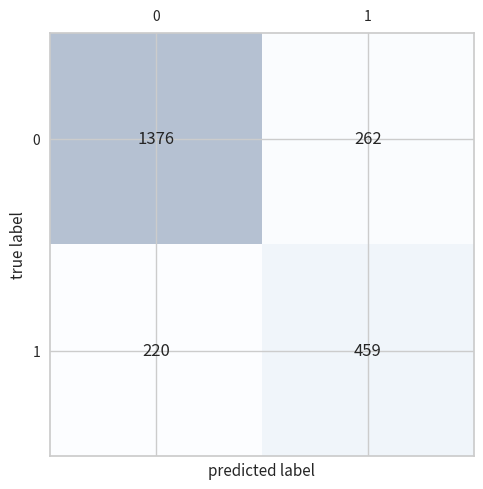

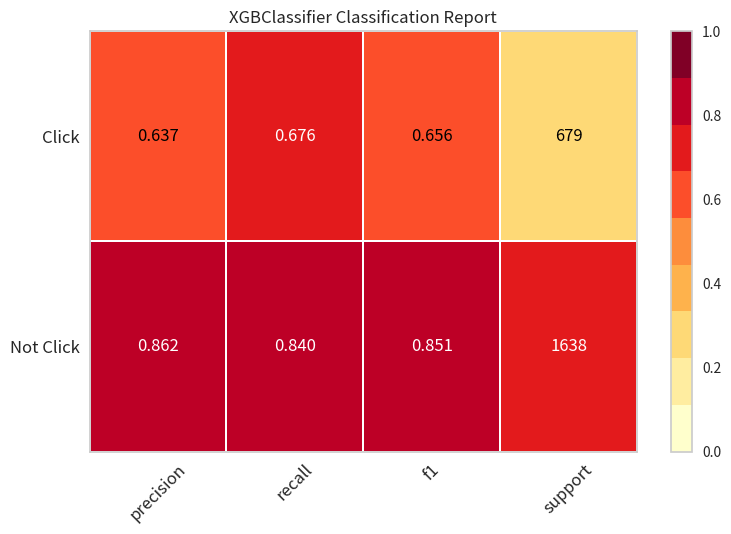

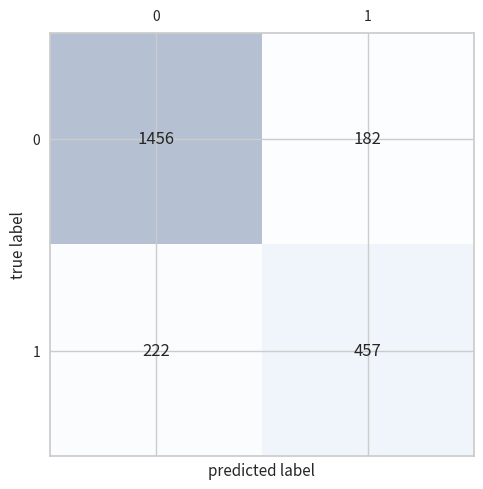

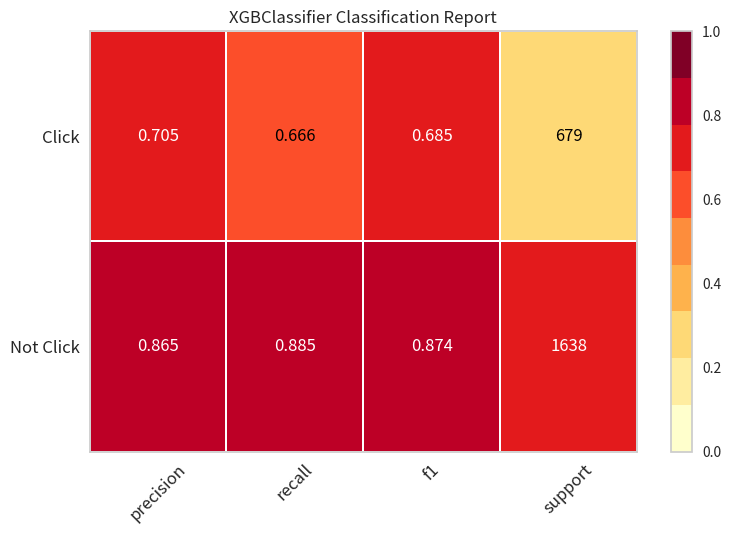

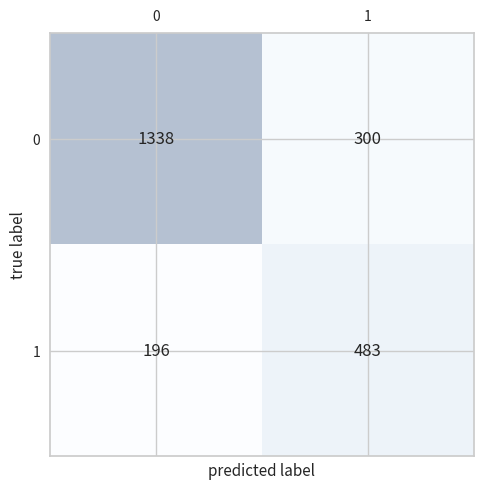

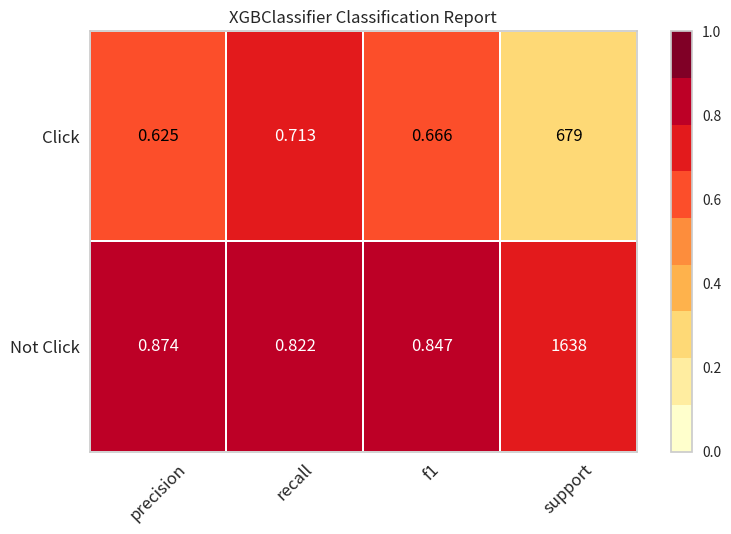

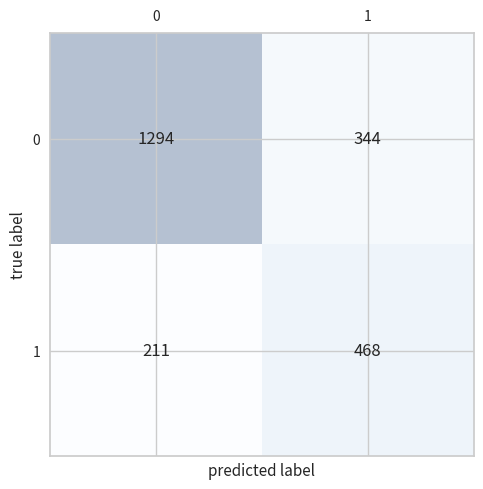

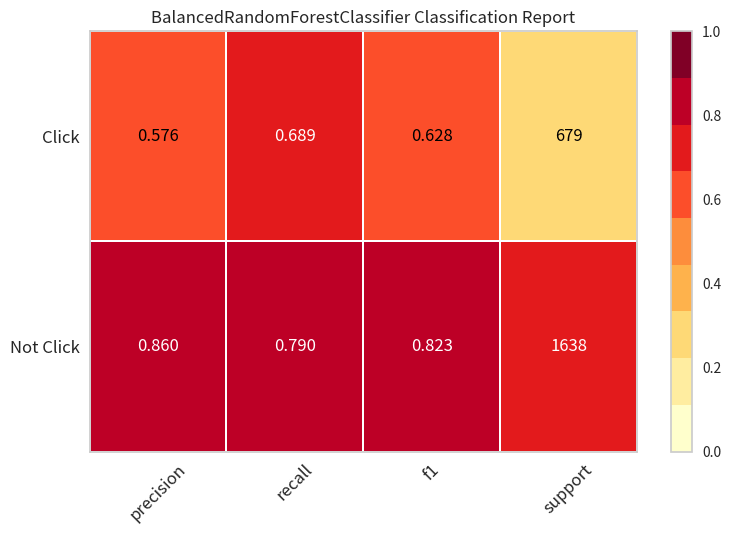

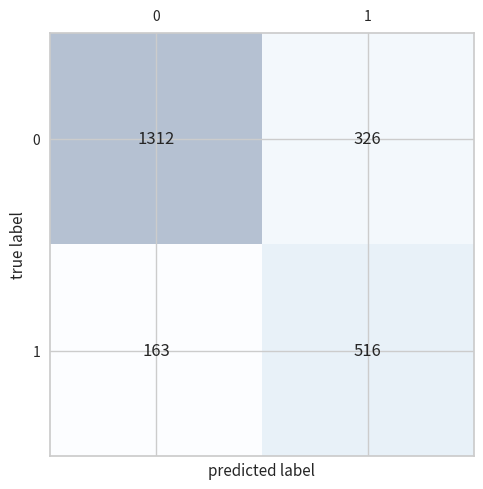

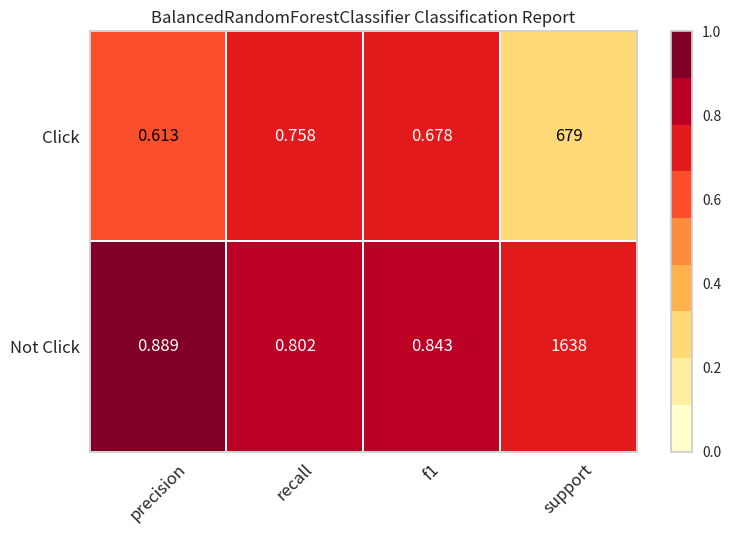

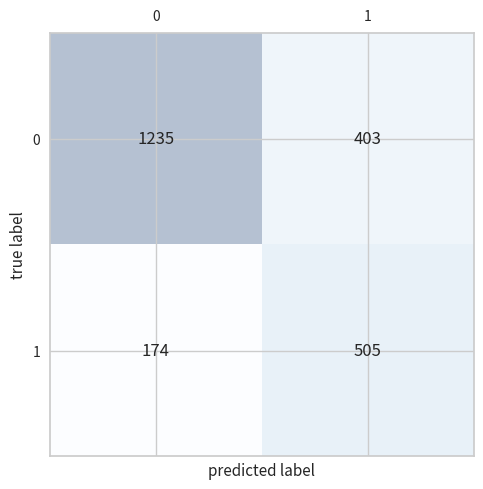

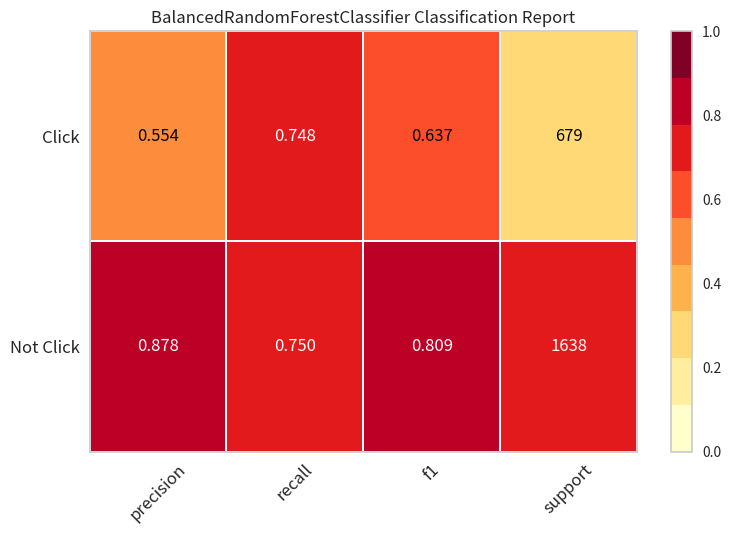

In [93]:
f1s = []
precisions = []
estimators = []

best_f1 = 0
best_estimator = None

for trained_RandomSearch_model in trained_RandomSearch_models:
    estimator = copy(trained_RandomSearch_model.best_estimator_)
    y_click_pred = estimator.predict(X_test)

    # 用自定義函式確認混淆矩陣和分類報告
    precision, f1 = predict_and_report(estimator, X_train, y_click_train,X_test, y_click_test, y_click_pred)
    
    estimators.append(estimator)
    precisions.append(precision)
    f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_estimator = estimator

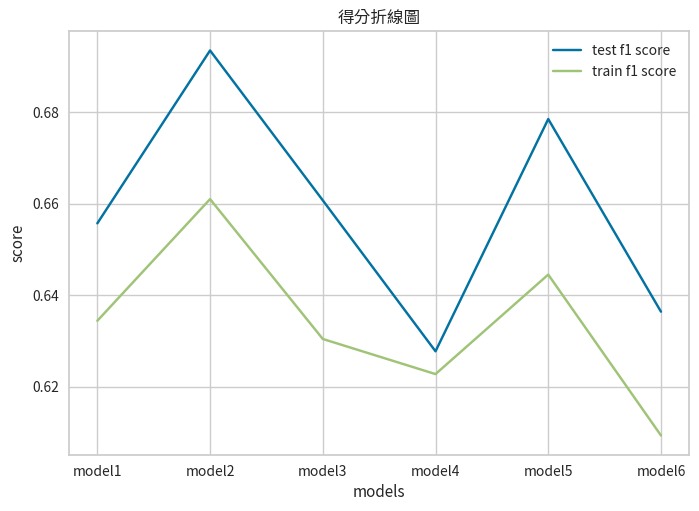

In [94]:
# 畫折線圖
plt.plot(f1s, label='test f1 score')
# plt.plot(precisions, label='test precision score')
plt.plot(train_scores, label='train f1 score')


# 改中文字形
plt.rcParams['font.sans-serif'] = ['Noto Sans TC']

# 設定圖表標題和軸標籤
plt.title('得分折線圖')
plt.xlabel('models')
plt.ylabel('score')

x_labels = [f"model{num+1}" for num in range(len(f1s))]
plt.xticks(range(len(x_labels)), x_labels)


# 加上圖例
plt.legend()

# 顯示圖表
plt.show()

In [95]:
best_estimator

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, min_df=2)),
                ('lsa', <__main__.LSA object at 0x0000028803BE22E0>),
                ('xgbc',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [96]:
model_path = "./models/"
model_filename = "model_click_best_f1.pkl"

# 若路徑不存在，就創路徑
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
# 儲存模型到指定路徑
with open( model_path + model_filename, "wb") as f:
    pickle.dump(best_estimator, f)

# **切分DailyNews訓練集測試集**

DailyNews

In [54]:
X_train, X_test, y_DailyNews_train, y_DailyNews_test = train_test_split(texts_df.texts, texts_df.DailyNews, test_size=0.2, random_state=42)

In [57]:
# 改成DailyNews的比例
xgbc_params['xgbc__scale_pos_weight'] = [(texts_df.DailyNews==0).sum()/(texts_df.DailyNews==1).sum()]

# **RandomSearchCV 找DailyNews最佳模型**

開始random search

In [58]:
# 跑BalancedRandomForestClassifier會有很多future warning警告，這邊把它關掉
warnings.filterwarnings("ignore")

trained_RandomSearch_models = []
for RandomSearch_model in tqdm(RandomSearch_models):
    # 在訓練集上進行隨機搜尋交叉驗證
    RandomSearch_model.fit(X_train, y_DailyNews_train)
    # 將結果放入串列trained_RandomSearch_models中
    trained_RandomSearch_models.append(RandomSearch_model)
    
warnings.filterwarnings("default") 

  0%|                                                                                                            | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 17%|████████████████▋                                                                                   | 1/6 [01:32<07:42, 92.52s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 33%|████████████████████████████████                                                                | 2/6 [29:08<1:07:29, 1012.47s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 50%|█████████████████████████████████████████████████▌                                                 | 3/6 [36:53<38:06, 762.05s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 67%|██████████████████████████████████████████████████████████████████                                 | 4/6 [38:10<16:23, 491.79s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


 83%|██████████████████████████████████████████████████████████████████████████████████▌                | 5/6 [45:51<08:00, 480.70s/it]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [53:06<00:00, 531.08s/it]


檢視各種pipeline的最佳模型，在訓練時的cv平均分數(精準度)

In [69]:
train_scores = []
for trained_RandomSearch_model in trained_RandomSearch_models:
    best_score = trained_RandomSearch_model.best_score_
    best_param = trained_RandomSearch_model.best_params_
    train_scores.append(best_score)
    print(best_score, best_param)

0.6000768089162517 {'xgbc__subsample': 0.9, 'xgbc__seed': 42, 'xgbc__scale_pos_weight': 4.016890428757038, 'xgbc__reg_lambda': 0.1, 'xgbc__reg_alpha': 1, 'xgbc__n_estimators': 100, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.5, 'xgbc__colsample_bytree': 0.5}
0.6233424464816107 {'xgbc__subsample': 0.9, 'xgbc__seed': 42, 'xgbc__scale_pos_weight': 4.016890428757038, 'xgbc__reg_lambda': 1, 'xgbc__reg_alpha': 10, 'xgbc__n_estimators': 100, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.1, 'xgbc__colsample_bytree': 0.9}
0.5716676373096556 {'xgbc__subsample': 0.9, 'xgbc__seed': 42, 'xgbc__scale_pos_weight': 4.016890428757038, 'xgbc__reg_lambda': 1, 'xgbc__reg_alpha': 1, 'xgbc__n_estimators': 50, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.1, 'xgbc__colsample_bytree': 0.7}
0.5377502415295269 {'brfc__random_state': 42, 'brfc__n_estimators': 200, 'brfc__min_samples_split': 5, 'brfc__min_samples_leaf': 1, 'brfc__max_features': 'log2', 'brfc__max_depth': 9, 'brfc__criterion': 'entropy'}
0.57

檢視model在驗證集上的表現

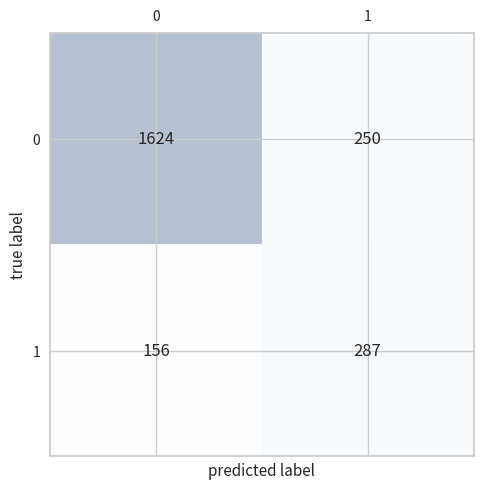

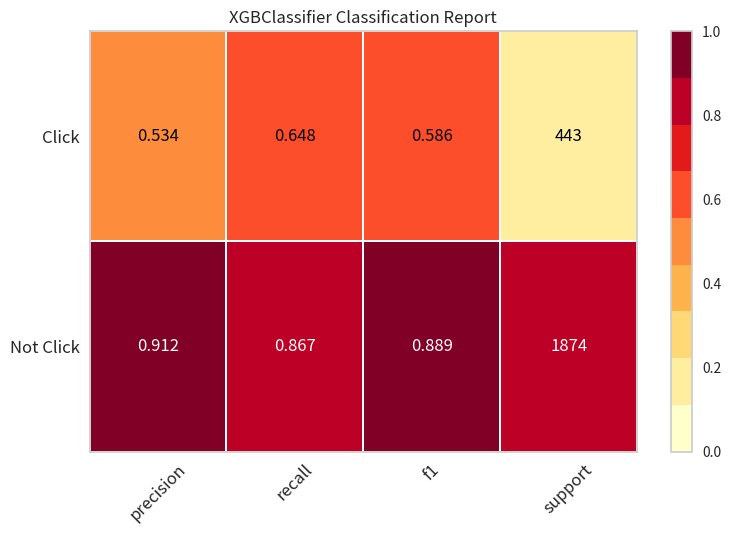

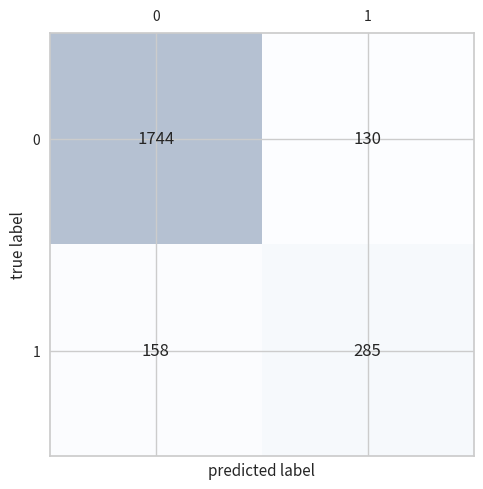

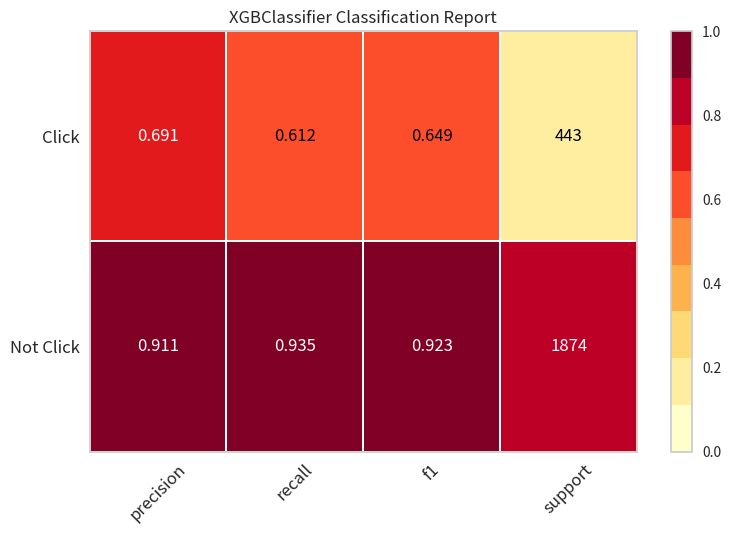

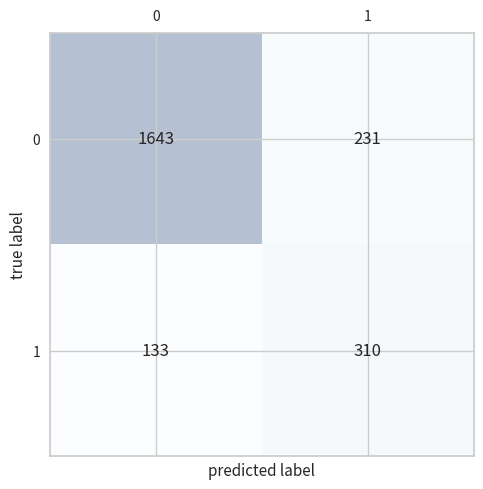

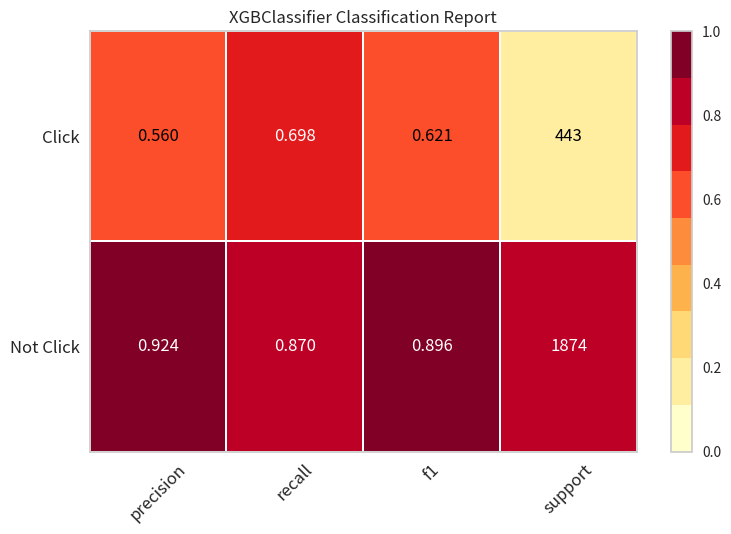

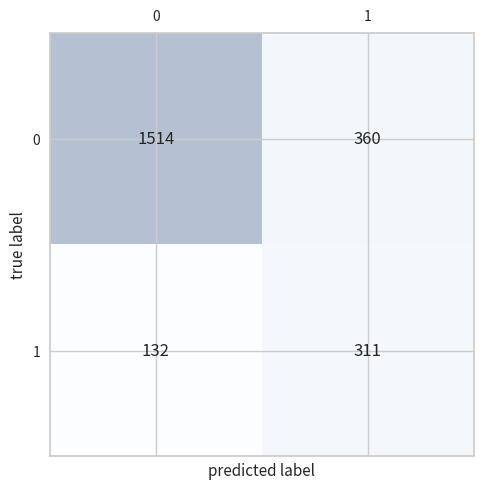

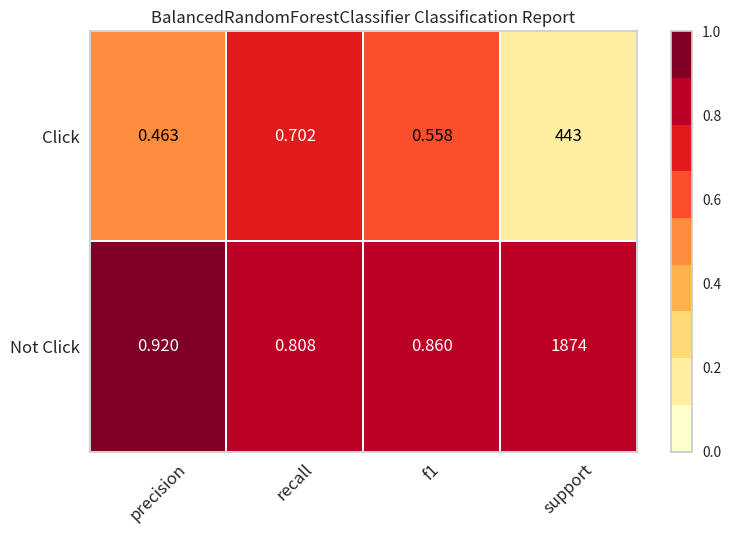

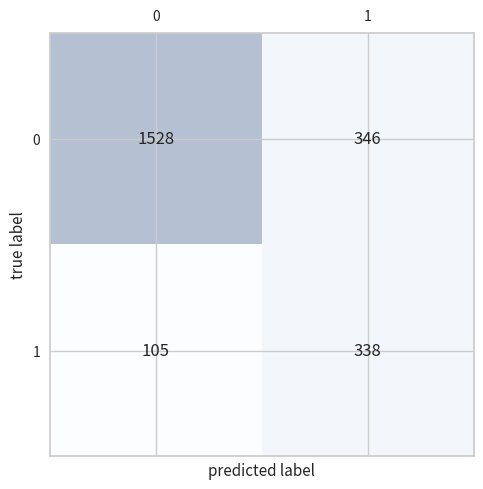

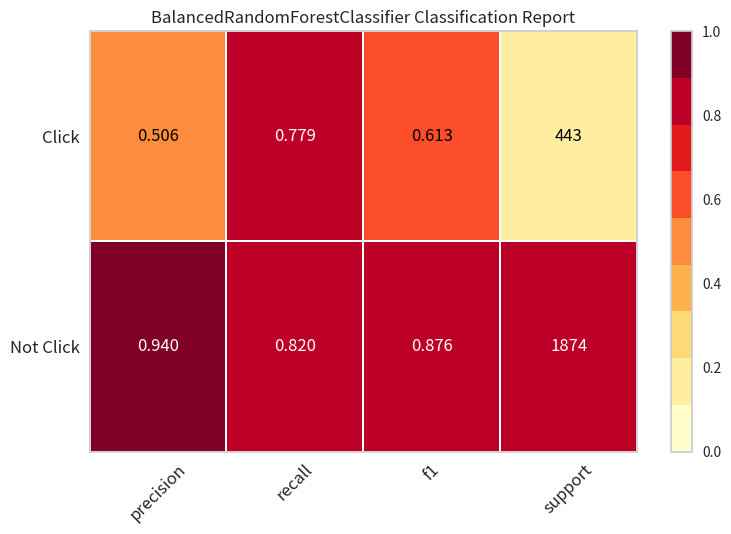

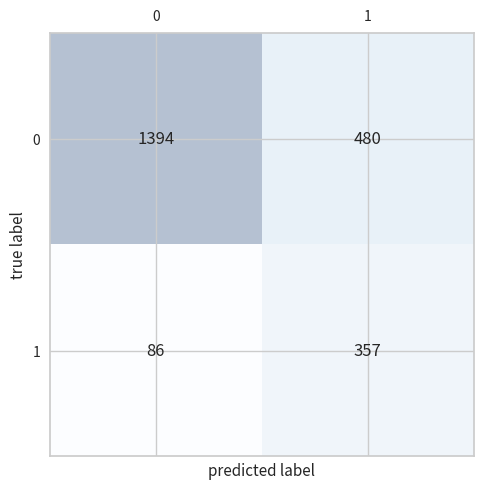

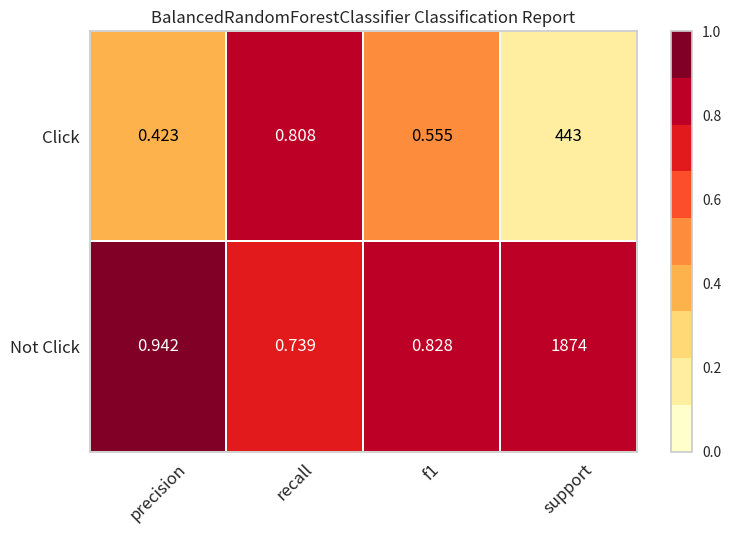

In [70]:
f1s = []
precisions = []
estimators = []

best_f1 = 0
best_estimator = None

for trained_RandomSearch_model in trained_RandomSearch_models:
    estimator = copy(trained_RandomSearch_model.best_estimator_)
    y_DailyNews_pred = estimator.predict(X_test)

    # 用自定義函式確認混淆矩陣和分類報告
    precision, f1 = predict_and_report(estimator, X_train, y_DailyNews_train,X_test, y_DailyNews_test, y_DailyNews_pred)
    
    estimators.append(estimator)
    precisions.append(precision)
    f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_estimator = estimator

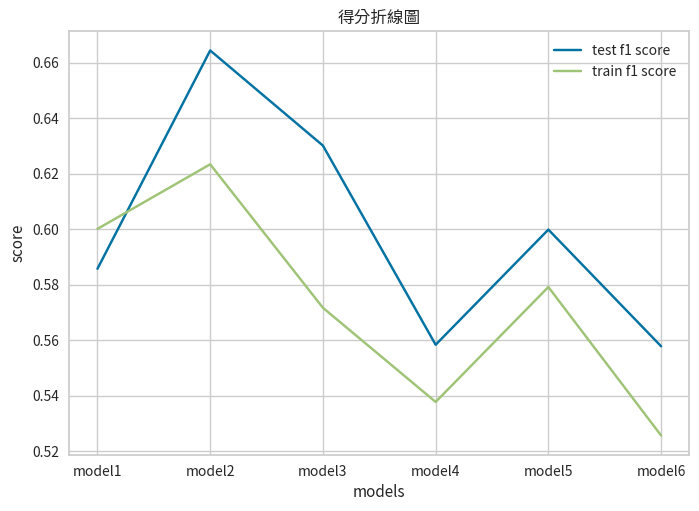

In [75]:
# 畫折線圖
plt.plot(f1s, label='test f1 score')
# plt.plot(precisions, label='test precision score')
plt.plot(train_scores, label='train f1 score')


# 改中文字形
plt.rcParams['font.sans-serif'] = ['Noto Sans TC']

# 設定圖表標題和軸標籤
plt.title('得分折線圖')
plt.xlabel('models')
plt.ylabel('score')

x_labels = [f"model{num+1}" for num in range(len(f1s))]
plt.xticks(range(len(x_labels)), x_labels)


# 加上圖例
plt.legend()

# 顯示圖表
plt.show()

In [72]:
best_estimator

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9, min_df=2)),
                ('lsa', <__main__.LSA object at 0x0000028801B87B80>),
                ('xgbc',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [73]:
model_path = "./models/"
model_filename = "model_DailyNews_best_f1.pkl"

# 若路徑不存在，就創路徑
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
# 儲存模型到指定路徑
with open( model_path + model_filename, "wb") as f:
    pickle.dump(best_estimator, f)

In [3]:
import os


In [ ]:
 """這個程式會在運行後開啟截圖模式，
    按下s鍵即可開啟截圖模式，
    按下z鍵即可關閉截圖模式，
    按下x鍵即可截圖。
    截圖後的圖片會按順序存儲在screenshots文件夾中，並用像screenshot_1.jpg這樣的格式進行命名。
    當你按下z鍵時，程式會將所有截圖整理成一個PDF文件，並存儲在screenshots文件夾中。"""

while True:
    if keyboard.is_pressed('x')


In [2]:
import os

from PIL import Image

def main():
    desc =
    print(desc)
    is_screenshot = False
    folder_name = "screenshots"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    index = 1
    images = []

    while True:
        key = pyautogui.confirm(text='Choose a key', buttons=['s', 'z', 'x', 'Stop'])
        
        if key == "s":
            print("截圖模式已啟動")
            is_screenshot = True

        if key == "z":
            print("截圖模式已關閉")
            is_screenshot = False
            # 生成 PDF 文件
            images.sort()
            pdf_name = "screenshots.pdf"
            pdf_path = os.path.join(folder_name, pdf_name)
            images[0].save(pdf_path, save_all=True, append_images=images[1:])
        
        if key == "x":
            if is_screenshot:
                im = pyautogui.screenshot()
                im = Image.fromarray(im)
                image_name = f"screenshot_{index}.jpg"
                image_path = os.path.join(folder_name, image_name)
                im.save(image_path)
                print(f"已截圖: {image_name}")
                images.append(im)
                index += 1

        if key == "Stop":
            break

if __name__ == '__main__':
    main()

這個程式會在運行後開啟截圖模式，
    按下s鍵即可開啟截圖模式，
    按下z鍵即可關閉截圖模式，
    按下x鍵即可截圖。
    截圖後的圖片會按順序存儲在screenshots文件夾中，並用像screenshot_1.jpg這樣的格式進行命名。
    當你按下z鍵時，程式會將所有截圖整理成一個PDF文件，並存儲在screenshots文件夾中。


程式開始
程式結束


In [2]:
path

'./screenshot/'

In [3]:
# image_files_idxs 會像是[1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
image_files_idxs = [int(png[:-4]) for png in os.listdir(path) if png.endswith(".png")]
# sort_image_files 會像是['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png']
sort_image_files = [path + str(idx) + '.png' for idx in sorted(image_files_idxs)]

['./screenshot/1.png',
 './screenshot/2.png',
 './screenshot/3.png',
 './screenshot/5.png',
 './screenshot/6.png',
 './screenshot/7.png',
 './screenshot/8.png',
 './screenshot/9.png',
 './screenshot/10.png',
 './screenshot/11.png',
 './screenshot/12.png',
 './screenshot/13.png',
 './screenshot/14.png',
 './screenshot/15.png',
 './screenshot/16.png',
 './screenshot/17.png',
 './screenshot/18.png',
 './screenshot/19.png',
 './screenshot/20.png',
 './screenshot/21.png']

In [12]:
from fpdf import FPDF
pdf = FPDF()

for image in sort_image_files:
    pdf.add_page()
    pdf.image(image,w=,h=)
pdf.output(path + input("pdf檔檔名")+".pdf", "F")

pdf檔檔名 測試


''

In [35]:
pdf.add_page?

Signature: pdf.add_page(orientation='')
Docstring: Start a new page
File:      c:\users\benbllee\appdata\local\programs\python\python38\lib\site-packages\fpdf\fpdf.py
Type:      method


In [16]:
from PIL import Image
from fpdf import FPDF

pdf = FPDF()

for image in sort_image_files:
    img = Image.open(image)
    width, height = img.size
    print(width, height)
    pdf.add_page(orientation = 'L')
    pdf.image(image, w=width, h=height)

output_file = path + input("pdf檔檔名") + ".pdf"
pdf.output(output_file, "F")

1029 96
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080
1920 1080


pdf檔檔名 sdfa


''

TypeError: add_page() got an unexpected keyword argument 'format'

'./screenshot/'

In [5]:
from os.path import isfile, join 
from pgmagick import Image



for each_file in listdir(path):
    if isfile(join(path,each_file)):
        image_path = os.path.join(path,each_file)
        pdf_path =  os.path.join(path,each_file.rsplit('.', 1)[0]+'.pdf')
        img = Image(image_path)
        img.write(pdf_path)



# for image in sort_image_files:
#     img = Image.open(image)
#     width, height = img.size
#     print(width, height)
#     pdf.add_page( format = '')
#     pdf.image(image)

# output_file = path + input("pdf檔檔名") + ".pdf"
# pdf.output(output_file, "F")

ModuleNotFoundError: No module named 'pgmagick'

In [ ]:
from PIL import Image
pdf_name = "screenshots.pdf"
pdf_path = os.path.join(path, pdf_name)
images[0].save(pdf_path, save_all=True, append_images=images[1:])

In [58]:
path

'./screenshot/'

In [60]:
pip install fpdf

Looking in indexes: http://autcbdpypi.corpnet.auo.com/simple
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40731 sha256=e28f37baf9915a3f8758fc62352ed2d0e4d054744fdd655399be5eaa8cfe12d3
  Stored in directory: c:\users\benbllee\appdata\local\pip\cache\wheels\95\6c\13\3209a0514cb273f28cfbf9d70e0318c87f3f79df7ac9128df6
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\benbllee\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.
